In [1]:
# !pip install torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
# !pip uninstall torch==2.4.1+cu121 torchvision==0.15.2+cu121 torchaudio==2.4.1
# !pip install torch==2.4.1+cu121 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

In [2]:
# !pip install lightning
# import torch
# import sys
# print(torch.__version__)
# version = 2.4.1+cu121
# import struct;print( 8 * struct.calcsize('P'))
# import lightning as L
# print(L.__version__)


In [3]:

# !pip install torch-summary torch-lr-finder timm easyfsl
# !pip install torch torchvision torchaudio
!pip install easyfsl
! pip install torch-summary
# !pip uninstall -y torch torchvision
# !pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 3.2 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import vgg11
from torchsummary import summary
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
# import lightning as L


In [5]:
# save the checkpoint:
def save_checkpoint(model, optimizer, epoch, mean_accuracy, std_accuracy, file_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at epoch {epoch} with mean accuracy: {mean_accuracy:.2f}%")
# usage :
# save_checkpoint(model, optimizer, epoch=10, mean_accuracy=mean_accuracy, std_accuracy=std_accuracy, file_path=save_path)

# Load the checkpoint
def load_checkpoint(file_path, model): # Removed optimizer from arguments
    checkpoint = torch.load(file_path, map_location=device)

    # Handle missing keys
    missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)

    if missing_keys:
        print("Warning: Missing keys in state_dict:", missing_keys)
    if unexpected_keys:
        print("Warning: Unexpected keys in state_dict:", unexpected_keys)

    epoch = checkpoint['epoch']
    mean_accuracy = checkpoint['mean_accuracy']
    std_accuracy = checkpoint['std_accuracy']
    print(f"Checkpoint loaded from epoch {epoch} with mean accuracy: {mean_accuracy:.2f}%")
    return epoch, mean_accuracy, std_accuracy, checkpoint['optimizer_state_dict'] # Return optimizer state dict

# usage:
# loaded_epoch, loaded_mean_accuracy, loaded_std_accuracy, optimizer_state_dict = load_checkpoint(save_path, model)

In [6]:
def save_checkpointmodel_optim(model, optimizer,epoch ,file_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch':epoch
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at path {file_path} at epoch {epoch}")


def load_checkpoint_modeoptim(file_path, model, optimizer):
    checkpoint = torch.load(file_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Set the path to your dataset
data_path = '/content/drive/MyDrive/minor_dataset/minor/dataset'  # Adjust this path

# Check the classes in the dataset
class_name = os.listdir(data_path)
print(class_name)

['Car', 'Truck', 'Pedestrians', 'Bike']


Number of samples in Car category: 1503
Number of samples in Truck category: 881
Number of samples in Pedestrians category: 30
Number of samples in Bike category: 820


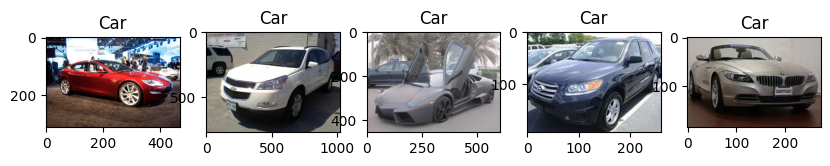

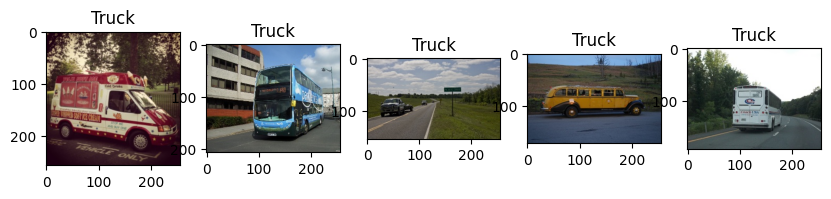

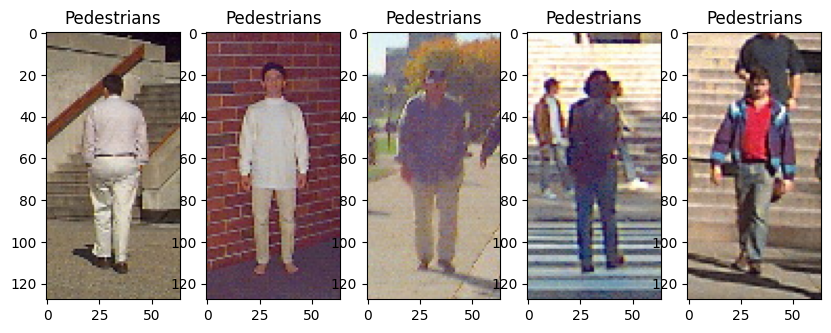

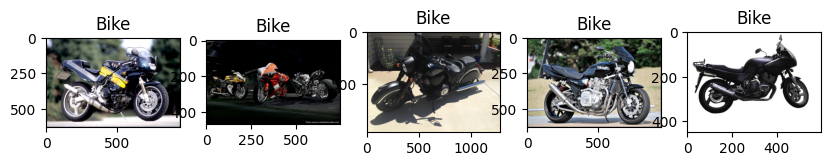

In [9]:
def get_count(each_class):
    return len(os.listdir(data_path + '/' + each_class))

for each_class in class_name:
    print(f"Number of samples in {each_class} category: {get_count(each_class)}")

directory = os.listdir(data_path)
for each in directory:
    plt.figure(figsize=(10, 10))
    currentFolder = data_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = data_path + '/' + each + "/" + file
        img = mpimg.imread(fullpath)
        ax = plt.subplot(1, 5, i + 1)
        ax.set_title(each)
        plt.imshow(img)

In [10]:
#regularisation L1

import abc

import torch
import torch.nn as nn

class WeightDecay(nn.Module):
    def __init__(self, module, weight_decay, name: str = None):
        if weight_decay < 0.0:
            raise ValueError(
                "Regularization's weight_decay should be greater than 0.0, got {}".format(
                    weight_decay
                )
            )

        super().__init__()
        self.module = module
        self.weight_decay = weight_decay
        self.name = name

        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    def remove(self):
        self.hook.remove()

    def _weight_decay_hook(self, *_):
        if self.name is None:
            for param in self.module.parameters():
                if param.grad is None or torch.all(param.grad == 0.0):
                    param.grad = self.regularize(param)
        else:
            for name, param in self.module.named_parameters():
                if self.name in name and (
                    param.grad is None or torch.all(param.grad == 0.0)
                ):
                    param.grad = self.regularize(param)

    def forward(self, *args, **kwargs):
        return self.module(*args, **kwargs)

    def extra_repr(self) -> str:
        representation = "weight_decay={}".format(self.weight_decay)
        if self.name is not None:
            representation += ", name={}".format(self.name)
        return representation

    @abc.abstractmethod
    def regularize(self, parameter):
        pass



class L1(WeightDecay):
    """Regularize module's parameters using L1 weight decay.

    Example::

        import torchlayers as tl

        # Regularize all parameters of Linear module
        regularized_layer = tl.L1(tl.Linear(30), weight_decay=1e-5)

    .. note::
            Backward hook will be registered on `module`. If you wish
            to remove `L1` regularization use `remove()` method.

    Parameters
    ----------
    module : torch.nn.Module
        Module whose parameters will be regularized.
    weight_decay : float
        Strength of regularization (has to be greater than `0.0`).
    name : str, optional
        Name of parameter to be regularized (if any).
        Default: all parameters will be regularized (including "bias").

    """

    def regularize(self, parameter):
        return self.weight_decay * torch.sign(parameter.data)

In [11]:
#WAV-KAN implementation :

import math

import torch
import torch.nn as nn


class WaveletConvND(nn.Module):
    def __init__(self, conv_class, input_dim, output_dim, kernel_size,
                 padding=0, stride=1, dilation=1,
                 ndim: int = 2, wavelet_type='mexican_hat'):
        super(WaveletConvND, self).__init__()

        _shapes = (1, output_dim, input_dim) + tuple(1 for _ in range(ndim))

        self.scale = nn.Parameter(torch.ones(*_shapes))
        self.translation = nn.Parameter(torch.zeros(*_shapes))

        self.ndim = ndim
        self.wavelet_type = wavelet_type

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.wavelet_weights = nn.ModuleList([conv_class(input_dim,
                                                         1,
                                                         kernel_size,
                                                         stride,
                                                         padding,
                                                         dilation,
                                                         groups=1,
                                                         bias=False) for _ in range(output_dim)])

        self.wavelet_out = conv_class(output_dim, output_dim, 1, 1, 0, dilation, groups=1, bias=False)

        for conv_layer in self.wavelet_weights:
            nn.init.kaiming_uniform_(conv_layer.weight, nonlinearity='linear')
        nn.init.kaiming_uniform_(self.wavelet_out.weight, nonlinearity='linear')

    @staticmethod
    def _forward_mexican_hat(x):
        term1 = ((x ** 2) - 1)
        term2 = torch.exp(-0.5 * x ** 2)
        wavelet = (2 / (math.sqrt(3) * math.pi ** 0.25)) * term1 * term2
        return wavelet

    @staticmethod
    def _forward_morlet(x):
        omega0 = 5.0  # Central frequency
        real = torch.cos(omega0 * x)
        envelope = torch.exp(-0.5 * x ** 2)
        wavelet = envelope * real
        return wavelet

    @staticmethod
    def _forward_dog(x):
        return -x * torch.exp(-0.5 * x ** 2)

    @staticmethod
    def _forward_meyer(x):
        v = torch.abs(x)
        pi = math.pi

        def meyer_aux(v):
            return torch.where(v <= 1 / 2, torch.ones_like(v),
                               torch.where(v >= 1, torch.zeros_like(v), torch.cos(pi / 2 * nu(2 * v - 1))))

        def nu(t):
            return t ** 4 * (35 - 84 * t + 70 * t ** 2 - 20 * t ** 3)

        # Meyer wavelet calculation using the auxiliary function
        wavelet = torch.sin(pi * v) * meyer_aux(v)
        return wavelet

    def _forward_shannon(self, x):
        pi = math.pi
        sinc = torch.sinc(x / pi)  # sinc(x) = sin(pi*x) / (pi*x)

        _shape = (1, 1, x.size(2)) + tuple(1 for _ in range(self.ndim))
        # Applying a Hamming window to limit the infinite support of the sinc function
        window = torch.hamming_window(x.size(2), periodic=False, dtype=x.dtype,
                                      device=x.device).view(*_shape)
        # Shannon wavelet is the product of the sinc function and the window
        wavelet = sinc * window
        return wavelet

    def forward(self, x):
        x_expanded = x.unsqueeze(1)

        x_scaled = (x_expanded - self.translation) / self.scale

        if self.wavelet_type == 'mexican_hat':
            wavelet = self._forward_mexican_hat(x_scaled)
        elif self.wavelet_type == 'morlet':
            wavelet = self._forward_morlet(x_scaled)
        elif self.wavelet_type == 'dog':
            wavelet = self._forward_dog(x_scaled)
        elif self.wavelet_type == 'meyer':
            wavelet = self._forward_meyer(x_scaled)
        elif self.wavelet_type == 'shannon':
            wavelet = self._forward_shannon(x_scaled)
        else:
            raise ValueError("Unsupported wavelet type")

        wavelet_x = torch.split(wavelet, 1, dim=1)
        output = []
        for group_ind, _x in enumerate(wavelet_x):
            y = self.wavelet_weights[group_ind](_x.squeeze(1))
            # output.append(y.clone())
            output.append(y)
        y = torch.cat(output, dim=1)
        y = self.wavelet_out(y)
        return y


class WaveletConvNDFastPlusOne(WaveletConvND):
    def __init__(self, conv_class, conv_class_d_plus_one, input_dim, output_dim, kernel_size,
                 padding=0, stride=1, dilation=1,
                 ndim: int = 2, wavelet_type='mexican_hat'):
        super(WaveletConvND, self).__init__()

        assert ndim < 3, "fast_plus_one version suppoerts only 1D and 2D convs"

        _shapes = (1, output_dim, input_dim) + tuple(1 for _ in range(ndim))

        self.scale = nn.Parameter(torch.ones(*_shapes))
        self.translation = nn.Parameter(torch.zeros(*_shapes))

        self.ndim = ndim
        self.wavelet_type = wavelet_type

        self.input_dim = input_dim
        self.output_dim = output_dim

        kernel_size_plus = (input_dim,) + kernel_size if isinstance(kernel_size, tuple) else (input_dim,) + (
        kernel_size,) * ndim
        stride_plus = (1,) + stride if isinstance(stride, tuple) else (1,) + (stride,) * ndim
        padding_plus = (0,) + padding if isinstance(padding, tuple) else (0,) + (padding,) * ndim
        dilation_plus = (1,) + dilation if isinstance(dilation, tuple) else (1,) + (dilation,) * ndim

        self.wavelet_weights = conv_class_d_plus_one(output_dim,
                                                     output_dim,
                                                     kernel_size_plus,
                                                     stride_plus,
                                                     padding_plus,
                                                     dilation_plus,
                                                     groups=output_dim,
                                                     bias=False)

        self.wavelet_out = conv_class(output_dim, output_dim, 1, 1, 0, dilation, groups=1, bias=False)

        nn.init.kaiming_uniform_(self.wavelet_weights.weight, nonlinearity='linear')
        nn.init.kaiming_uniform_(self.wavelet_out.weight, nonlinearity='linear')

    def forward(self, x):
        x_expanded = x.unsqueeze(1)

        x_scaled = (x_expanded - self.translation) / self.scale

        if self.wavelet_type == 'mexican_hat':
            wavelet = self._forward_mexican_hat(x_scaled)
        elif self.wavelet_type == 'morlet':
            wavelet = self._forward_morlet(x_scaled)
        elif self.wavelet_type == 'dog':
            wavelet = self._forward_dog(x_scaled)
        elif self.wavelet_type == 'meyer':
            wavelet = self._forward_meyer(x_scaled)
        elif self.wavelet_type == 'shannon':
            wavelet = self._forward_shannon(x_scaled)
        else:
            raise ValueError("Unsupported wavelet type")
        # wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
        # wavelet_output = wavelet_weighted.sum(dim=2)

        y = self.wavelet_weights(wavelet).squeeze(2)
        y = self.wavelet_out(y)
        return y


class WaveletConvNDFast(WaveletConvND):
    def __init__(self, conv_class, input_dim, output_dim, kernel_size,
                 padding=0, stride=1, dilation=1,
                 ndim: int = 2, wavelet_type='mexican_hat'):
        super(WaveletConvND, self).__init__()

        _shapes = (1, output_dim, input_dim) + tuple(1 for _ in range(ndim))

        self.scale = nn.Parameter(torch.ones(*_shapes))
        self.translation = nn.Parameter(torch.zeros(*_shapes))

        self.ndim = ndim
        self.wavelet_type = wavelet_type

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.wavelet_weights = conv_class(output_dim * input_dim,
                                          output_dim,
                                          kernel_size,
                                          stride,
                                          padding,
                                          dilation,
                                          groups=output_dim,
                                          bias=False)

        self.wavelet_out = conv_class(output_dim, output_dim, 1, 1, 0, dilation, groups=1, bias=False)

        nn.init.kaiming_uniform_(self.wavelet_weights.weight, nonlinearity='linear')
        nn.init.kaiming_uniform_(self.wavelet_out.weight, nonlinearity='linear')

    def forward(self, x):
        x_expanded = x.unsqueeze(1)

        x_scaled = (x_expanded - self.translation) / self.scale

        if self.wavelet_type == 'mexican_hat':
            wavelet = self._forward_mexican_hat(x_scaled)
        elif self.wavelet_type == 'morlet':
            wavelet = self._forward_morlet(x_scaled)
        elif self.wavelet_type == 'dog':
            wavelet = self._forward_dog(x_scaled)
        elif self.wavelet_type == 'meyer':
            wavelet = self._forward_meyer(x_scaled)
        elif self.wavelet_type == 'shannon':
            wavelet = self._forward_shannon(x_scaled)
        else:
            raise ValueError("Unsupported wavelet type")
        # wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
        # wavelet_output = wavelet_weighted.sum(dim=2)

        y = self.wavelet_weights(wavelet.flatten(1, 2))
        y = self.wavelet_out(y)
        return y



class WavKANConvNDLayer(nn.Module):
    def __init__(self, conv_class, conv_class_plus1, norm_class, input_dim, output_dim, kernel_size,
                 groups=1, padding=0, stride=1, dilation=1, wav_version: str = 'base',
                 ndim: int = 2, dropout=0.0, wavelet_type='mexican_hat', **norm_kwargs):
        super(WavKANConvNDLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.dilation = dilation
        self.groups = groups
        self.ndim = ndim
        self.norm_kwargs = norm_kwargs
        assert wavelet_type in ['mexican_hat', 'morlet', 'dog', 'meyer', 'shannon'], \
            ValueError(f"Unsupported wavelet type: {wavelet_type}")
        self.wavelet_type = wavelet_type

        self.dropout = None
        if dropout > 0:
            if ndim == 1:
                self.dropout = nn.Dropout1d(p=dropout)
            if ndim == 2:
                self.dropout = nn.Dropout2d(p=dropout)
            if ndim == 3:
                self.dropout = nn.Dropout3d(p=dropout)
        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if input_dim % groups != 0:
            raise ValueError('input_dim must be divisible by groups')
        if output_dim % groups != 0:
            raise ValueError('output_dim must be divisible by groups')

        self.base_conv = nn.ModuleList([conv_class(input_dim // groups,
                                                   output_dim // groups,
                                                   kernel_size,
                                                   stride,
                                                   padding,
                                                   dilation,
                                                   groups=1,
                                                   bias=False) for _ in range(groups)])
        if wav_version == 'base':
            self.wavelet_conv = nn.ModuleList(
                [
                    WaveletConvND(
                        conv_class,
                        input_dim // groups,
                        output_dim // groups,
                        kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                        ndim=ndim, wavelet_type=wavelet_type
                    ) for _ in range(groups)
                ]
            )
        elif wav_version == 'fast':
            self.wavelet_conv = nn.ModuleList(
                [
                    WaveletConvNDFast(
                        conv_class,
                        input_dim // groups,
                        output_dim // groups,
                        kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                        ndim=ndim, wavelet_type=wavelet_type
                    ) for _ in range(groups)
                ]
            )
        elif wav_version == 'fast_plus_one':

            self.wavelet_conv = nn.ModuleList(
                [
                    WaveletConvNDFastPlusOne(
                        conv_class, conv_class_plus1,
                        input_dim // groups,
                        output_dim // groups,
                        kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                        ndim=ndim, wavelet_type=wavelet_type
                    ) for _ in range(groups)
                ]
            )

        self.layer_norm = nn.ModuleList([norm_class(output_dim // groups, **norm_kwargs) for _ in range(groups)])

        self.base_activation = nn.SiLU()

    def forward_wavkan(self, x, group_ind):
        # You may like test the cases like Spl-KAN
        base_output = self.base_conv[group_ind](self.base_activation(x))

        if self.dropout is not None:
            x = self.dropout(x)

        wavelet_output = self.wavelet_conv[group_ind](x)

        combined_output = wavelet_output + base_output

        # Apply batch normalization
        return self.layer_norm[group_ind](combined_output)

    def forward(self, x):
        split_x = torch.split(x, self.inputdim // self.groups, dim=1)
        output = []
        for group_ind, _x in enumerate(split_x):
            y = self.forward_wavkan(_x, group_ind)
            output.append(y.clone())
        y = torch.cat(output, dim=1)
        return y


class WavKANConv2DLayer(WavKANConvNDLayer):
    def __init__(self, input_dim, output_dim, kernel_size, groups=1, padding=0, stride=1, dilation=1,
                 dropout=0.0, wavelet_type='mexican_hat', norm_layer=nn.BatchNorm2d,
                 wav_version: str = 'fast', **norm_kwargs):
        super(WavKANConv2DLayer, self).__init__(nn.Conv2d, nn.Conv3d, norm_layer, input_dim, output_dim, kernel_size,
                                                groups=groups, padding=padding, stride=stride, dilation=dilation,
                                                ndim=2, dropout=dropout, wavelet_type=wavelet_type,
                                                wav_version=wav_version, **norm_kwargs)


#utils:

def wav_kan_conv3x3(in_planes: int, out_planes: int, groups: int = 1, stride: int = 1,
                    dilation: int = 1, l1_decay: float = 0.0, dropout: float = 0.0,
                    wavelet_type: str = 'mexican_hat', wav_version: str = 'fast', **norm_kwargs) -> WavKANConv2DLayer:
    """3x3 convolution with padding"""
    conv = WavKANConv2DLayer(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        dilation=dilation,
        groups=groups,
        wavelet_type=wavelet_type,
        wav_version=wav_version,
        dropout=dropout,
        **norm_kwargs
    )
    if l1_decay > 0:
        conv = L1(conv, l1_decay)
    return conv



In [12]:
# layers code:
import torch.nn.functional as F

class WavKANLayer(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='mexican_hat'):
        super(WavKANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type

        # Parameters for wavelet transformation
        self.scale = nn.Parameter(torch.ones(out_features, in_features))
        self.translation = nn.Parameter(torch.zeros(out_features, in_features))

        # Linear weights for combining outputs
        # self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight1 = nn.Parameter(torch.Tensor(out_features,
                                                 in_features))  # not used; you may like to use it for wieghting base activation and adding it like Spl-KAN paper
        self.wavelet_weights = nn.Parameter(torch.Tensor(out_features, in_features))

        nn.init.kaiming_uniform_(self.wavelet_weights, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weight1, a=math.sqrt(5))

        # Base activation function #not used for this experiment
        self.base_activation = nn.SiLU()

        # Batch normalization
        self.bn = nn.BatchNorm1d(out_features)

    def wavelet_transform(self, x):
        if x.dim() == 2:
            x_expanded = x.unsqueeze(1)
        else:
            x_expanded = x

        translation_expanded = self.translation.unsqueeze(0).expand(x.size(0), -1, -1)
        scale_expanded = self.scale.unsqueeze(0).expand(x.size(0), -1, -1)
        x_scaled = (x_expanded - translation_expanded) / scale_expanded

        # Implementation of different wavelet types
        if self.wavelet_type == 'mexican_hat':
            term1 = ((x_scaled ** 2) - 1)
            term2 = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = (2 / (math.sqrt(3) * math.pi ** 0.25)) * term1 * term2
        elif self.wavelet_type == 'morlet':
            omega0 = 5.0  # Central frequency
            real = torch.cos(omega0 * x_scaled)
            envelope = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = envelope * real

        elif self.wavelet_type == 'dog':
            # Implementing Derivative of Gaussian Wavelet
            wavelet = -x_scaled * torch.exp(-0.5 * x_scaled ** 2)
        elif self.wavelet_type == 'meyer':
            # Implement Meyer Wavelet here
            # Constants for the Meyer wavelet transition boundaries
            v = torch.abs(x_scaled)
            pi = math.pi

            def meyer_aux(v):
                return torch.where(v <= 1 / 2, torch.ones_like(v),
                                   torch.where(v >= 1, torch.zeros_like(v), torch.cos(pi / 2 * nu(2 * v - 1))))

            def nu(t):
                return t ** 4 * (35 - 84 * t + 70 * t ** 2 - 20 * t ** 3)

            # Meyer wavelet calculation using the auxiliary function
            wavelet = torch.sin(pi * v) * meyer_aux(v)
        elif self.wavelet_type == 'shannon':
            # Windowing the sinc function to limit its support
            pi = math.pi
            sinc = torch.sinc(x_scaled / pi)  # sinc(x) = sin(pi*x) / (pi*x)

            # Applying a Hamming window to limit the infinite support of the sinc function
            window = torch.hamming_window(x_scaled.size(-1), periodic=False, dtype=x_scaled.dtype,
                                          device=x_scaled.device)
            # Shannon wavelet is the product of the sinc function and the window
            wavelet = sinc * window

            # You can try many more wavelet types ...
        else:
            raise ValueError("Unsupported wavelet type")
        wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
        wavelet_output = wavelet_weighted.sum(dim=2)
        return wavelet_output

    def forward(self, x):
        wavelet_output = self.wavelet_transform(x)
        # You may like test the cases like Spl-KAN
        # wav_output = F.linear(wavelet_output, self.weight)
        base_output = F.linear(self.base_activation(x), self.weight1)

        # base_output = F.linear(x, self.weight1)
        combined_output = wavelet_output + base_output

        # Apply batch normalization
        return self.bn(combined_output)




#utils :
class WavKAN(nn.Module):
    def __init__(self, layers_hidden, dropout: float = 0.0, l1_decay: float = 0.0,
                 first_dropout: bool = True, wavelet_type: str = 'mexican_hat', **kwargs):
        super(WavKAN, self).__init__()  # Initialize the parent nn.Module class

        assert wavelet_type in ['mexican_hat', 'morlet', 'dog', 'meyer', 'shannon'], \
            ValueError(f"Unsupported wavelet type: {wavelet_type}")
        # layers_hidden: A list of integers specifying the number of neurons in each layer
        self.layers_hidden = layers_hidden
        # polynomial_order: Order up to which Legendre polynomials are calculated
        self.wavelet_type = wavelet_type
        # list of layers
        self.layers = nn.ModuleList([])
        if dropout > 0 and first_dropout:
            self.layers.append(nn.Dropout(p=dropout))
        self.num_layers = len(layers_hidden[:-1])

        for i, (in_features, out_features) in enumerate(zip(layers_hidden[:-1], layers_hidden[1:])):
            # Base weight for linear transformation in each layer
            layer = WavKANLayer(in_features, out_features, wavelet_type=wavelet_type)
            if l1_decay > 0 and i != self.num_layers - 1:
                layer = L1(layer, l1_decay)
            self.layers.append(layer)

            if dropout > 0 and i != self.num_layers - 1:
                self.layers.append(nn.Dropout(p=dropout))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def mlp_wav_kan(layers_hidden, dropout: float = 0.0,
                wavelet_type: str = 'mexican_hat', l1_decay: float = 0.0) -> WavKAN:
    return WavKAN(layers_hidden, dropout=dropout, wavelet_type=wavelet_type, l1_decay=l1_decay)




In [13]:
# vgg cfgs dictionaries:

from typing import Dict, List, Union

cfgs: Dict[str, List[Union[str, int]]] = {
    "VGG11": [16, "M", 32, "M", 64, 64, "M", 128, 128, "M", 128, 128],
    "VGG13": [16, 16, "M", 32, 32, "M", 64, 64, "M", 128, 128, "M", 128, 128],
    "VGG16": [16, 16, "M", 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "M", 128, 128, 128],
    "VGG19": [16, 16, "M", 32, 32, "M", 64, 64, 64, 64, "M", 128, 128, 128, 128, "M", 128, 128, 128, 128],

    "VGG11sa": [16, "M", 32, "M", 64, 64, "SAM", 128, 128, "SAM", 128, 128],
    "VGG13sa": [16, 16, "M", 32, 32, "M", 64, 64, "SAM", 128, 128, "SAM", 128, 128],
    "VGG16sa": [16, 16, "M", 32, 32, "M", 64, 64, 64, "SAM", 128, 128, 128, "SAM", 128, 128, 128],
    "VGG19sa": [16, 16, "M", 32, 32, "M", 64, 64, 64, 64, "SAM", 128, 128, 128, 128, "SAM", 128, 128, 128, 128],

    "VGG11v2": [16, "M", 32, "M", 64, 64, "M", 128, 128, "M", 128, 128, "M", 128, 128],
    "VGG13v2": [16, 16, "M", 32, 32, "M", 64, 64, "M", 128, 128, "M", 128, 128, "M", 128, 128],
    "VGG16v2": [16, 16, "M", 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "M", 128, 128, 128, "M", 128, 128],
    "VGG19v2": [16, 16, "M", 32, 32, "M", 64, 64, 64, 64, "M", 128, 128, 128, 128, "M", 128, 128, 128, 128, "M", 128,
                128],
    "VGG11v3": [16, "M", 32, "M", 64, 64, "M", 128, 128, "M", 128, 128, "M", 128, 256],
    "VGG13v3": [16, 16, "M", 32, 32, "M", 64, 64, "M", 128, 128, "M", 128, 128, "M", 128, 256],
    "VGG16v3": [16, 16, "M", 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "M", 128, 128, 128, "M", 128, 256],
    "VGG19v3": [16, 16, "M", 32, 32, "M", 64, 64, 64, 64, "M", 128, 128, 128, 128, "M", 128, 128, 128, 128, "M", 128,
                256],
    "VGG11v4": [16, "M", 32, "M", 64, 64, "M", 128, 128, "M", 128, 128, "M", 256, 256],
    "VGG13v4": [16, 16, "M", 32, 32, "M", 64, 64, "M", 128, 128, "M", 128, 128, "M", 256, 256],
    "VGG16v4": [16, 16, "M", 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "M", 128, 128, 128, "M", 256, 256],
    "VGG19v4": [16, 16, "M", 32, 32, "M", 64, 64, 64, 64, "M", 128, 128, 128, 128, "M", 128, 128, 128, 128, "M", 256,
                256],
    "VGG11v4sa": [16, "M", 32, "M", 64, 64, "M", 128, 128, "SAM", 128, 128, "SAM", 256, 256],
    "VGG13v4sa": [16, 16, "M", 32, 32, "M", 64, 64, "M", 128, 128, "SAM", 128, 128, "SAM", 256, 256],
    "VGG16v4sa": [16, 16, "M", 32, 32, "M", 64, 64, 64, "M", 128, 128, 128, "SAM", 128, 128, 128, "SAM", 256, 256],
    "VGG19v4sa": [16, 16, "M", 32, 32, "M", 64, 64, 64, 64, "M", 128, 128, 128, 128, "SAM", 128, 128, 128, 128, "SAM", 256,
                256]
}



In [14]:
# vgg-11 Model:

from typing import Tuple,cast
from functools import partial
from huggingface_hub import PyTorchModelHubMixin
from math import prod

class VGG(nn.Module):
    def __init__(
            self, features: nn.ModuleList, classifier: nn.Module, expected_feature_shape: Tuple = (7, 7)
    ) -> None:
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(expected_feature_shape)
        self.classifier = classifier
        self.expected_feature_shape = expected_feature_shape

    @staticmethod
    def make_layers(cfg: List[Union[str, int]],
                    head_type,
                    conv_fun,
                    conv_fun_first,
                    kan_fun,
                    kan_att_fun=None,
                    expected_feature_shape: Tuple = (7, 7),
                    num_input_features: int = 3,
                    num_classes: int = 1000,
                    width_scale: int = 1,
                    head_dropout: float = 0.5,
                    last_attention: bool = False
                    ):
        layers: List[nn.Module] = []
        in_channels = num_input_features
        for l_index, v in enumerate(cfg):
            if v == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif v == 'SAM':
                layers += [kan_att_fun(in_channels), nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                v = cast(int, v)
                if l_index == 0:
                    conv2d = conv_fun_first(in_channels, v * width_scale)
                elif l_index == len(cfg) - 1 and last_attention:
                    conv2d = kan_att_fun(in_channels)
                else:
                    conv2d = conv_fun(in_channels, v * width_scale)
                layers.append(conv2d)
                in_channels = v * width_scale
        if head_type == 'KAN':
            classification = kan_fun([in_channels * prod(expected_feature_shape), num_classes])
        elif head_type == 'HiddenKAN':
            classification = nn.Sequential(
                kan_fun([in_channels * prod(expected_feature_shape), 512]),
                nn.Dropout(p=head_dropout),
                nn.Linear(512, num_classes),
            )
        elif head_type == 'VGG':
            classification = nn.Sequential(
                nn.Linear(in_channels * prod(expected_feature_shape), 1024),
                nn.ReLU(True),
                nn.Dropout(p=head_dropout),
                nn.Linear(1024, 1024),
                nn.ReLU(True),
                nn.Dropout(p=head_dropout),
                nn.Linear(1024, num_classes),
            )
        elif head_type == 'Linear':
            classification = nn.Sequential(
                nn.Dropout(p=head_dropout),
                nn.Linear(in_channels * prod(expected_feature_shape), num_classes),
            )
            # deleted matryoshka if else blocks check "torch-conv-kan/models /vggkan.py" VGG class line num 114 to 126
        else:
            classification = None

        return nn.ModuleList(layers), classification

    def forward_features(self, x):
        moe_loss = None
        for layer in self.features:
            x = layer(x)
            if isinstance(x, tuple):
                x, _moe = x
                if moe_loss is None:
                    moe_loss = _moe
                else:
                    moe_loss = moe_loss + _moe
        if moe_loss is not None:
            return x, moe_loss
        return x

    def forward(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        moe_loss = None
        x = self.forward_features(x)
        if isinstance(x, tuple):
            x, moe_loss = x
        if self.classifier is None:
            return x
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        if moe_loss is not None:
            return x, moe_loss
        return x


class WavVVGKAN(VGG, PyTorchModelHubMixin):
    def __init__(self, input_channels, num_classes, groups: int = 1,
                 wavelet_type: str = 'mexican_hat', wav_version: str = 'fast',
                 dropout: float = 0.0, l1_decay: float = 0.0,
                 dropout_linear: float = 0.25, vgg_type: str = 'VGG11', head_type: str = 'Linear',
                 expected_feature_shape: Tuple = (7, 7), width_scale: int = 1,
                 norm_layer: nn.Module = nn.InstanceNorm2d, affine: bool = False):
        conv_fun = partial(wav_kan_conv3x3, wavelet_type=wavelet_type, wav_version=wav_version,
                           dropout=dropout, l1_decay=l1_decay, groups=groups, norm_layer=norm_layer, affine=affine)
        conv_fun_first = partial(wav_kan_conv3x3, wavelet_type=wavelet_type, wav_version=wav_version,
                                 l1_decay=l1_decay, norm_layer=norm_layer, affine=affine)
        kan_fun = partial(mlp_wav_kan, wavelet_type=wavelet_type,
                          dropout=dropout_linear, l1_decay=l1_decay)

        features, head = self.make_layers(cfgs[vgg_type], head_type, conv_fun, conv_fun_first, kan_fun,
                                          expected_feature_shape=expected_feature_shape,
                                          num_input_features=input_channels, num_classes=num_classes,
                                          width_scale=width_scale,
                                          head_dropout=dropout_linear)
        super().__init__(features, head, expected_feature_shape)


def vgg_wav_kan(input_channels, num_classes, groups: int = 1,
                wavelet_type: str = 'mexican_hat', wav_version: str = 'fast',
                dropout: float = 0.0, l1_decay: float = 0.0,
                dropout_linear: float = 0.25, vgg_type: str = 'VGG11', head_type: str = 'Linear',
                expected_feature_shape: Tuple = (7, 7), width_scale: int = 1,
                norm_layer: nn.Module = nn.InstanceNorm2d, affine: bool = False):
    return WavVVGKAN(input_channels, num_classes, groups=groups,
                     wavelet_type=wavelet_type, wav_version=wav_version,
                     dropout=dropout, l1_decay=l1_decay,
                     dropout_linear=dropout_linear, vgg_type=vgg_type, head_type=head_type,
                     expected_feature_shape=expected_feature_shape, width_scale=width_scale,
                     norm_layer=norm_layer, affine=affine)

In [15]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat([z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)])
        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores



In [16]:
# Use vgg-11 as the backbone
# convolutional_network.fc = nn.Flatten()  # Flatten the output of the backbone's last layer

pretrained_model = vgg11()

convolutional_network = vgg_wav_kan(3,4)

pretrained_model_dict = pretrained_model.state_dict()

model_dict = convolutional_network.state_dict()  # Get your model's state dict

# Load weights from pre-trained model into your model's state dict, skipping irrelevant layers
for name, param in pretrained_model_dict.items():
    if name in model_dict and not name.startswith('classifier'):  # Skip classifier layers
        model_dict[name].copy_(param)

# print(model_dict)

convolutional_network.load_state_dict(model_dict,strict=True)  # Load the modified state dict


<All keys matched successfully>

In [17]:
from torchsummary import summary
Layer (type:depth-idx)                   Param #
=================================================================
├─WavVVGKAN: 1-1                         --
|    └─ModuleList: 2-1                   --
|    |    └─WavKANConv2DLayer: 3-1       1,216
|    |    └─MaxPool2d: 3-2               --
|    |    └─WavKANConv2DLayer: 3-3       11,264
|    |    └─MaxPool2d: 3-4               --
|    |    └─WavKANConv2DLayer: 3-5       45,056
|    |    └─WavKANConv2DLayer: 3-6       86,016
|    |    └─MaxPool2d: 3-7               --
|    |    └─WavKANConv2DLayer: 3-8       180,224
|    |    └─WavKANConv2DLayer: 3-9       344,064
|    |    └─MaxPool2d: 3-10              --

vgg_wav_kan.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network)



summary(model, input_size=(3, 224, 224))

# print(model)

Layer (type:depth-idx)                   Param #
├─WavVVGKAN: 1-1                         --
|    └─ModuleList: 2-1                   --
|    |    └─WavKANConv2DLayer: 3-1       1,216
|    |    └─MaxPool2d: 3-2               --
|    |    └─WavKANConv2DLayer: 3-3       11,264
|    |    └─MaxPool2d: 3-4               --
|    |    └─WavKANConv2DLayer: 3-5       45,056
|    |    └─WavKANConv2DLayer: 3-6       86,016
|    |    └─MaxPool2d: 3-7               --
|    |    └─WavKANConv2DLayer: 3-8       180,224
|    |    └─WavKANConv2DLayer: 3-9       344,064
|    |    └─MaxPool2d: 3-10              --
|    |    └─WavKANConv2DLayer: 3-11      344,064
|    |    └─WavKANConv2DLayer: 3-12      344,064
|    └─AdaptiveAvgPool2d: 2-2            --
|    └─Sequential: 2-3                   --
|    |    └─Dropout: 3-13                --
|    |    └─Linear: 3-14                 25,092
Total params: 1,381,060
Trainable params: 1,381,060
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─WavVVGKAN: 1-1                         --
|    └─ModuleList: 2-1                   --
|    |    └─WavKANConv2DLayer: 3-1       1,216
|    |    └─MaxPool2d: 3-2               --
|    |    └─WavKANConv2DLayer: 3-3       11,264
|    |    └─MaxPool2d: 3-4               --
|    |    └─WavKANConv2DLayer: 3-5       45,056
|    |    └─WavKANConv2DLayer: 3-6       86,016
|    |    └─MaxPool2d: 3-7               --
|    |    └─WavKANConv2DLayer: 3-8       180,224
|    |    └─WavKANConv2DLayer: 3-9       344,064
|    |    └─MaxPool2d: 3-10              --
|    |    └─WavKANConv2DLayer: 3-11      344,064
|    |    └─WavKANConv2DLayer: 3-12      344,064
|    └─AdaptiveAvgPool2d: 2-2            --
|    └─Sequential: 2-3                   --
|    |    └─Dropout: 3-13                --
|    |    └─Linear: 3-14                 25,092
Total params: 1,381,060
Trainable params: 1,381,060
Non-trainable params: 0

In [18]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []

        self.class_names = sorted(os.listdir(data_path))
        for label, class_name in enumerate(self.class_names):
            current_folder = os.path.join(data_path, class_name)
            for i, file in enumerate(os.listdir(current_folder)):
                fullpath = os.path.join(current_folder, file)
                self.images.append(fullpath)
                self.labels.append(label)

                # Check if the image can be opened and loaded successfully
                # try:
                #     # Attempt to open and load the image
                #     with Image.open(fullpath) as im:
                #         im.load()  # Force loading the image data

                #     self.images.append(fullpath)
                #     self.labels.append(label)
                # except IOError:
                #     print(f"Skipping corrupted image: {fullpath}")  # Log the skipped image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # Open image within a try-except block to catch potential errors
        try:
            image = Image.open(img_path)
        except IOError:
            print(f"Error opening image: {img_path}")
            return None, None  # Return None for both image and label if error

        # Check if image is palette with transparency
        if image.mode == 'P' and 'transparency' in image.info:
            image = image.convert('RGBA')

        image = image.convert('RGB')  # Ensure RGB format for consistency

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [19]:
N_WAY = 4  # Numbker of classes in a task
N_SHOT = 15  # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_EVALUATION_TASKS = 50

test_set = CustomDataset(data_path, transform=transform)
test_set.get_labels = lambda: [instance[1] for instance in zip(test_set.images, test_set.labels)]

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=False,
    collate_fn=test_sampler.episodic_collate_fn,
)


In [20]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  device_id = torch.cuda.current_device()
    # Print the name of the current CUDA device
  print(f"CUDA Device Name: {torch.cuda.get_device_name(device_id)}")
else:
    print("CUDA is not available.")

model.to(device)

CUDA Device Name: Tesla T4


PrototypicalNetworks(
  (backbone): WavVVGKAN(
    (features): ModuleList(
      (0): WavKANConv2DLayer(
        (base_conv): ModuleList(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (wavelet_conv): ModuleList(
          (0): WaveletConvNDFast(
            (wavelet_weights): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (wavelet_out): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (layer_norm): ModuleList(
          (0): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (base_activation): SiLU()
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): WavKANConv2DLayer(
        (base_conv): ModuleList(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (wavelet_conv

In [21]:
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    support_images = support_images.to(device)
    support_labels = support_labels.to(device)
    query_images = query_images.to(device)
    query_labels = query_labels.to(device)

    with torch.no_grad():
        output = model(support_images, support_labels, query_images)
    predicted_labels = torch.max(output, 1)[1]
    correct_predictions = (predicted_labels == query_labels).sum().item()
    return correct_predictions, len(query_labels)

def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0

    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct

    accuracy = 100 * correct_predictions / total_predictions
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2f}%")
    return accuracy



In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

load_checkpoint_modeoptim(file_path="/content/drive/MyDrive/minor_dataset/minor/checkpoints/Copy of minor at 66%.pt",model=model,optimizer=optimizer)

accuracies = []
for _ in range(5):  # Adjust the number of evaluation episodes
    accuracy = evaluate(test_loader)
    accuracies.append(accuracy)

mean_accuracy = np.mean(accuracies)
std_deviation = np.std(accuracies)
print(f"Mean Accuracy: {mean_accuracy:.2f}%, Standard deviation : {std_deviation:.2f}%")

<ipython-input-6-3d7d7d512d3d>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=device)
100%|██████████| 50/50 [05:09<00:00,

Model tested on 50 tasks. Accuracy: 64.00%



100%|██████████| 50/50 [03:19<00:00,  3.99s/it]

Model tested on 50 tasks. Accuracy: 63.50%



100%|██████████| 50/50 [03:17<00:00,  3.95s/it]

Model tested on 50 tasks. Accuracy: 69.50%



100%|██████████| 50/50 [03:15<00:00,  3.90s/it]

Model tested on 50 tasks. Accuracy: 63.50%



100%|██████████| 50/50 [03:14<00:00,  3.89s/it]

Model tested on 50 tasks. Accuracy: 63.50%
Mean Accuracy: 64.80%, Standard deviation : 2.36%
